# 1. Preparation

In [1]:
import pandas as pd
import numpy as np
from helper_functions import *

RANDOM_SEED = 42

cleaned_df = processing_data(path="C:\\Users\\lee39\\OneDrive\\Desktop\\new_final_merged_dataset.csv",
                             time_from_admission=True)

categorical_features = ["gender",
                        "ethnicity",
                        "admission_type",
                        "has_COPD",
                        "has_Diabetes",
                        "has_Metastasis",
                        "has_Sepsis_A41_9"]


C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Clustering

In [2]:
X_data, t_data, e_data, categorical_features_list, numerical_features_list = (
    processing_data_2_DCM(df=cleaned_df,
                          categorical_features_list=categorical_features,
                          train_test_val_size=(0.7, 0.2, 0.1),
                          random_seed=RANDOM_SEED,
                          clustering=True,
                          n_clusters=3,
                          )
)
X_train, X_val, X_test = X_data
t_train, t_val, t_test = t_data
e_train, e_val, e_test = e_data

train_set = (X_train, t_train, e_train)
val_set = (X_val, t_val, e_val)
test_set = (X_test, t_test, e_test)

In [3]:
# t_train, t_val, t_test = t_train[X_train["has_Sepsis_A41_9_1.0"] == 1], t_val[X_val["has_Sepsis_A41_9_1.0"] == 1], t_test[X_test["has_Sepsis_A41_9_1.0"] == 1]
#
# e_train, e_val, e_test = e_train[X_train["has_Sepsis_A41_9_1.0"] == 1], e_val[X_val["has_Sepsis_A41_9_1.0"] == 1], e_test[X_test["has_Sepsis_A41_9_1.0"] == 1]
#
# X_train, X_val, X_test = X_train[X_train["has_Sepsis_A41_9_1.0"] == 1], X_val[X_val["has_Sepsis_A41_9_1.0"] == 1], X_test[X_test["has_Sepsis_A41_9_1.0"] == 1]

# 3. Fit the models

## 3.1 DCM model

In [4]:
from sklearn.model_selection import ParameterGrid

DCM_param_grid = {"k" : [3],
                  "learning_rate" : [1e-3],
                  "layers": [[50, 50]],
                  "iters": [100]
             }
DCM_params = ParameterGrid(DCM_param_grid)

In [5]:
dcm_wrap = DCM_Wrapper(DCM_params)
dcm_wrap.fit(train_set=[data.drop("cluster index", axis=1).squeeze() for data in train_set],
             val_set=[data.drop("cluster index", axis=1).squeeze() for data in val_set])
dcm_model = dcm_wrap.model

  0%|          | 0/100 [00:00<?, ?it/s]C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: divide by zero encountered in log
  probs = gates+np.log(event_probs)
  7%|▋         | 7/100 [00:26<05:54,  3.81s/it]C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:53: RuntimeWarning: invalid value encountered in power
  s0ts = (-risks)*(spl(ts)**(risks-1))
 31%|███       | 31/100 [01:56<04:18,  3.75s/it]


In [6]:
train_latent = dcm_model.predict_latent_z(X_train.drop("cluster index", axis=1).squeeze())

train_group = np.argmax(train_latent, axis=1)
np.unique(train_group)

array([0, 1, 2], dtype=int64)

In [7]:
# get the name of covariates exclude the treatment
covariates = list(X_train.columns.drop(["treatment_1.0", "cluster index"]))

df_ps = pd.concat([X_train.drop("cluster index", axis=1).squeeze(),
                   t_train.drop("cluster index", axis=1).squeeze(),
                   e_train], axis=1)

df_ps = compute_PS_and_IPTW(df=df_ps,
                            covariates=covariates,
                            treatment="treatment_1.0")

KeyError: "['treatment_1.0'] not found in axis"

C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks


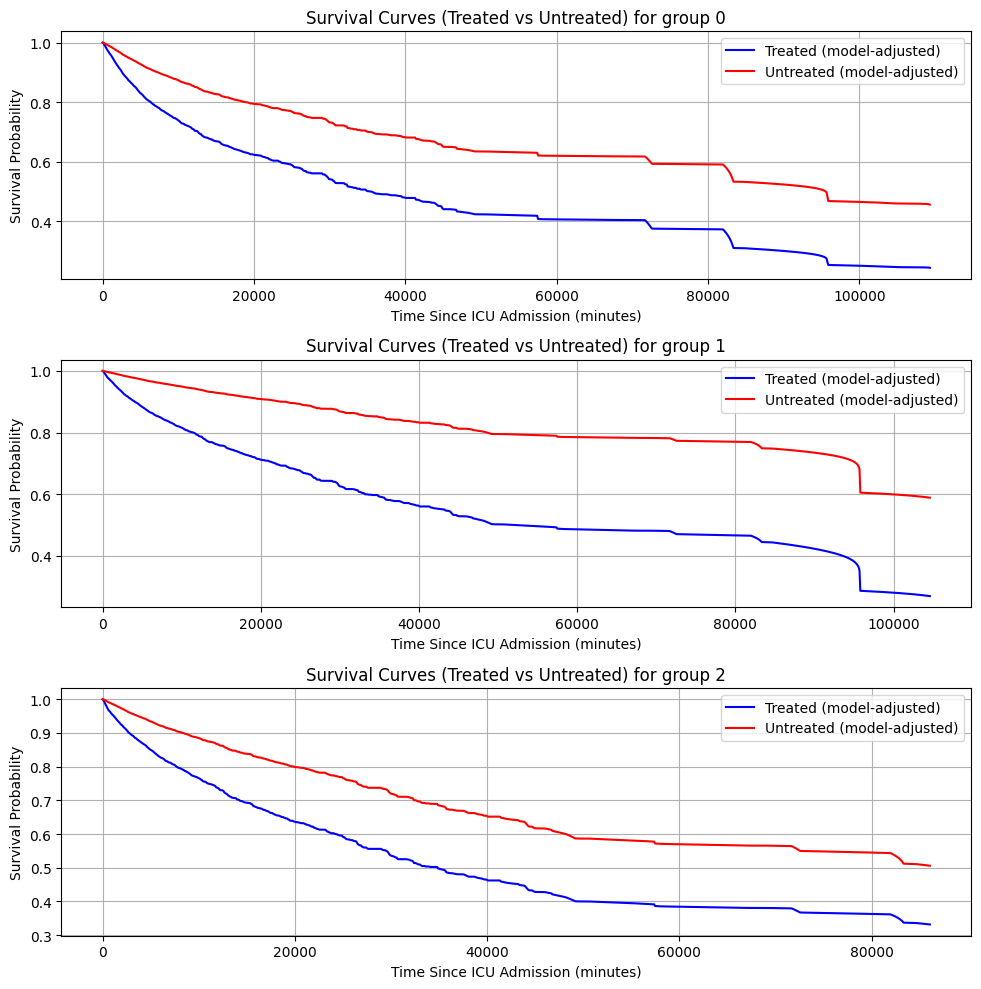

In [34]:
dcm_causal_effects = plot_avg_survival_curve(df=df_ps,
                                             group_index=train_group,
                                             model_wrapper=dcm_wrap,
                                             covariates=covariates,
                                             treatment="treatment_1.0",
                                             num_time=1000,
                            )

In [35]:
print(f"DCM model:")
for i, ce in enumerate(dcm_causal_effects):
    print(f"For group {i}, the estimated causal effect: {ce}.")

DCM model:
For group 0, the estimated causal effect: nan.
For group 1, the estimated causal effect: -26795.087638827397.
For group 2, the estimated causal effect: -14345.716154149311.


## 3.2 Cox Regression model

In [8]:
CR_param_grid = {"penalty": [1e-3]
             }
CR_params = ParameterGrid(CR_param_grid)

In [10]:
CR_params["penalty"]

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

In [9]:
list_CRs = clustering_fit_model(model_name="Cox Regression Model",
                                params_grid=CR_params,
                                train_set=train_set,
                                val_set=val_set)

TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'str'

For group 0:


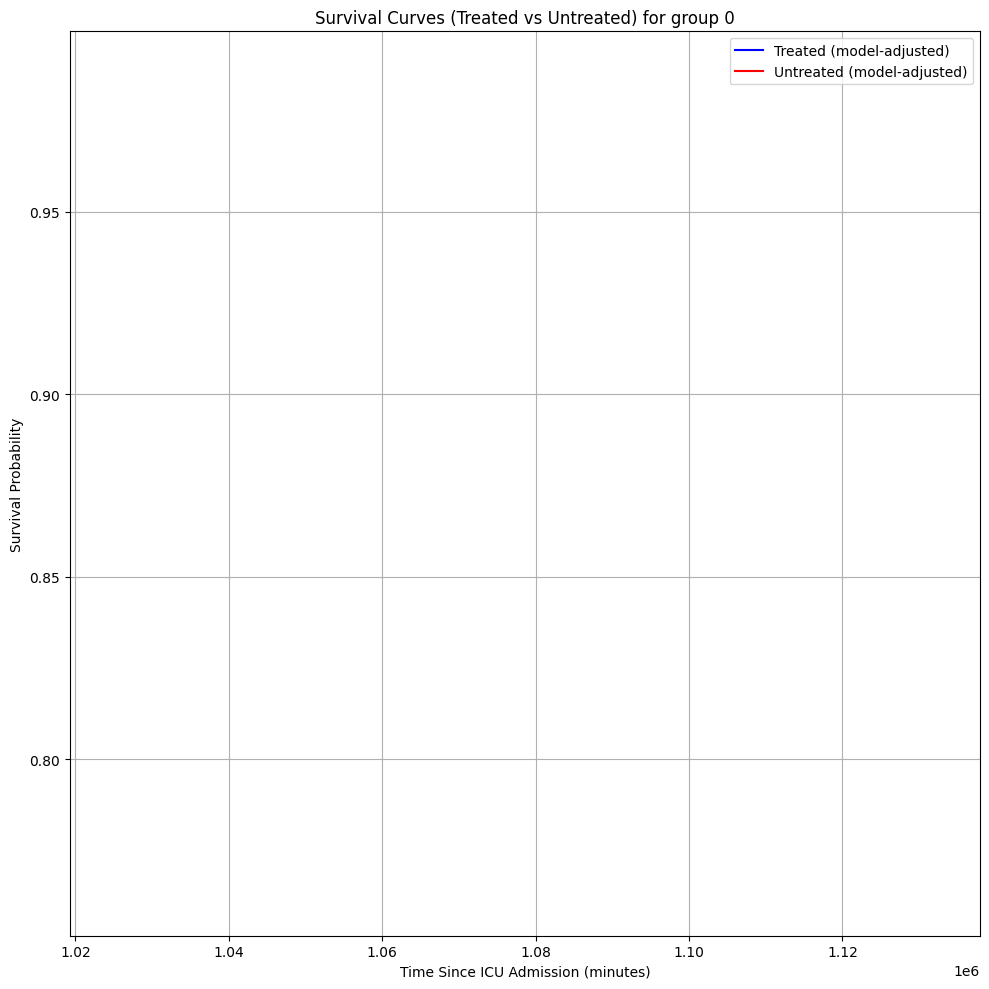

For group 1:


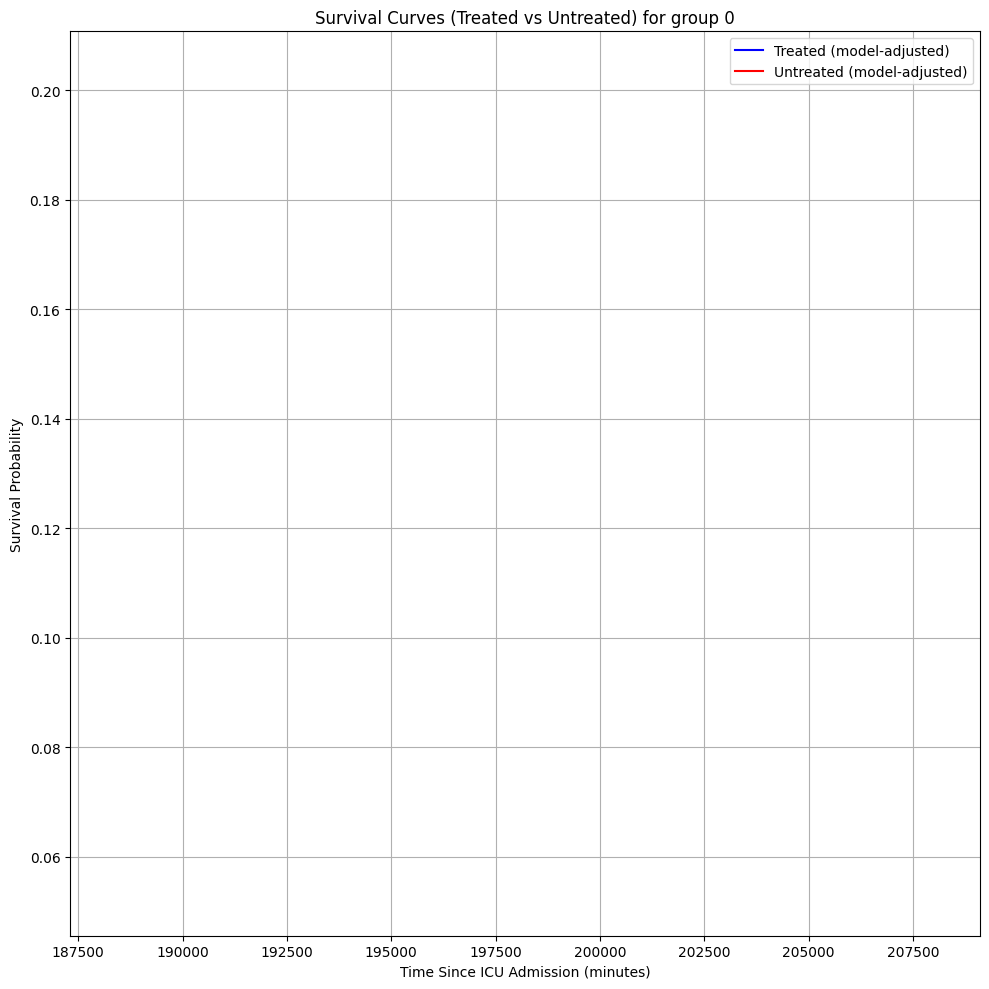

For group 2:


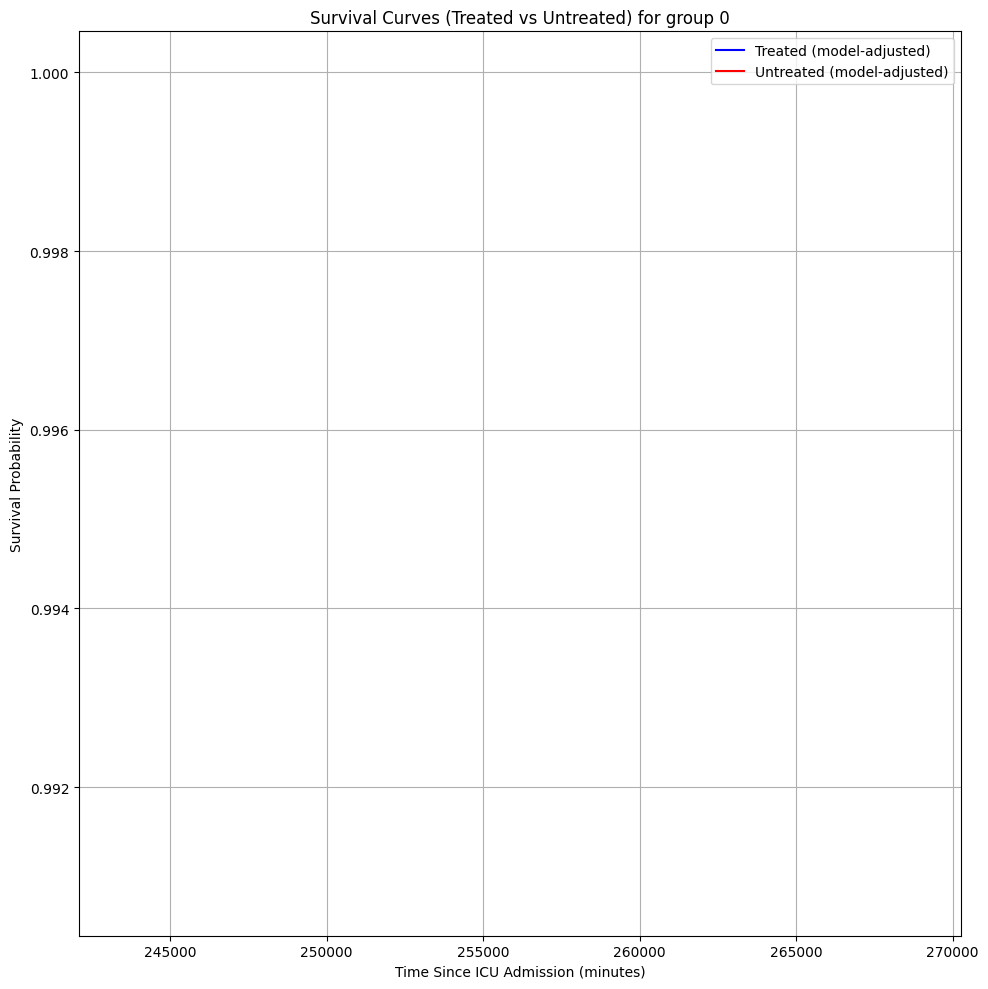

In [24]:
cr_causal_effects_list = []
for i, cr_wrap in enumerate(list_CRs):
    print(f"For group {i}:")
    cr_causal_effects_list.append(plot_avg_survival_curve(df=df_ps[df_ps["cluster index"] == i],
                                                          group_index=np.zeros((df_ps["cluster index"] == i).sum()),
                                                          model_wrapper=cr_wrap,
                                                          covariates=covariates,
                                                          treatment="treatment_1.0",
                                                          num_time=1000,
                                                          )
                                  )

In [15]:
print(f"Cox Regression model:")
for i, ce in enumerate(cr_causal_effects_list):
    print(f"For cluster {i}, the estimated causal effect: {ce}.")

Cox Regression model:
For cluster 0, the estimated causal effect: [nan].
For cluster 1, the estimated causal effect: [nan].
For cluster 2, the estimated causal effect: [nan].
